#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 16
**CH16A Predicting apartment prices with random forest**
using the airbnb dataset

version 0.9 2020-09-11

In [38]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from plotnine import *
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
import sys
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

In [2]:
# Current script folder
current_path = os.getcwd()
dirname = "/".join(current_path.split("/")[:-2]) + "/"

# location folders
data_in = dirname + "da_data_repo/world-bank-immunization/clean/"
data_out = dirname + "da_case_studies/ch23-immunization-life/"
output = dirname + "da_case_studies/ch23-immunization-life/output/"

func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)

In [3]:
# Import the prewritten helper functions 
from py_helper_functions import *

In [593]:
# Import data

data = pd.read_stata(data_in + "world-bank_immunization-continents.dta")

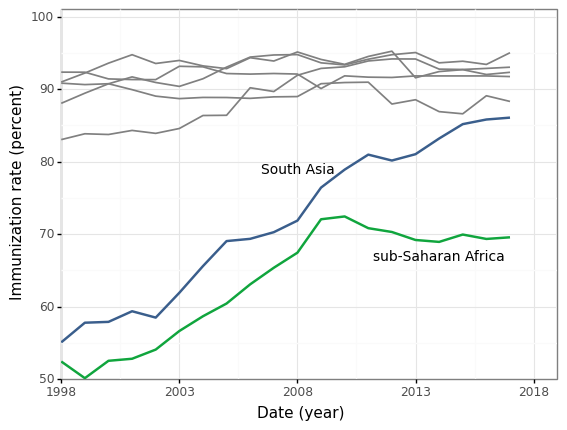

<ggplot: (301943580)>

In [594]:
p1 = (
    ggplot(data, aes(x="year", y="imm6"))
    + geom_line(color=color[0], size=1)
    + geom_line(aes(x="year", y="imm7"), color=color[1], size=1)
    + annotate(
        geom="text",
        x=data.loc[12, "year"] - 2,
        y=data.loc[12, "imm6"],
        label="South Asia",
        size=10,
    )
    + annotate(
        geom="text",
        x=data.loc[16, "year"],
        y=data.loc[16, "imm7"] - 2,
        label="sub-Saharan Africa",
        size=10,
    )
    + labs(y="Immunization rate (percent)", x="Date (year)")
    + scale_y_continuous(expand=(0, 0), breaks=range(50, 101, 10), limits=(50, 101))
    + scale_x_continuous(
        expand=(0, 0), breaks=range(1998, 2019, 5), limits=(1998, 2019)
    )
    + theme_bw()
)

for i in range(1, 6):
    p1 += geom_line(aes(x="year", y="imm" + str(i)), color="grey", size=0.7)
    
p1

In [595]:
for i in range(1, 8):
    data["surv" + str(i)] = data["surv" + str(i)] / 10

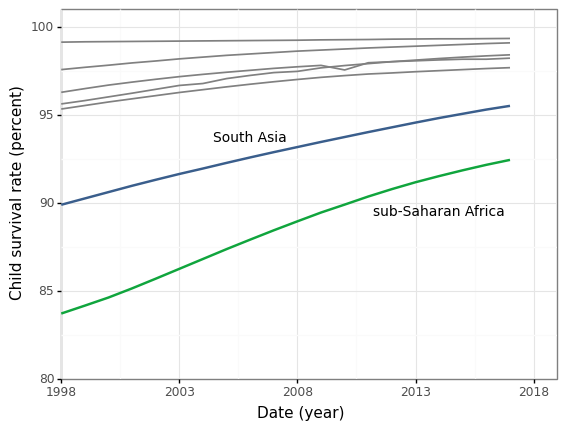

<ggplot: (302057792)>

In [596]:
p2 = (
    ggplot(data, aes(x="year", y="surv6"))
    + geom_line(color=color[0], size=1)
    + geom_line(aes(x="year", y="surv7"), color=color[1], size=1)
    + annotate(
        geom="text",
        x=data.loc[12, "year"] - 4,
        y=data.loc[12, "surv6"],
        label="South Asia",
        size=10,
    )
    + annotate(
        geom="text",
        x=data.loc[16, "year"],
        y=data.loc[16, "surv7"] - 2,
        label="sub-Saharan Africa",
        size=10,
    )
    + labs(y="Child survival rate (percent)", x="Date (year)")
    + scale_y_continuous(expand=(0, 0), breaks=range(80, 101, 5), limits=(80, 101))
    + scale_x_continuous(
        expand=(0, 0), breaks=range(1998, 2019, 5), limits=(1998, 2019)
    )
    + theme_bw()
)

for i in range(1, 6):
    p2 += geom_line(aes(x="year", y="surv" + str(i)), color="grey", size=0.7)

p2

In [95]:
# regressions on countries

data_panel = pd.read_stata(data_in + "world-bank_immunization-panel.dta")

In [96]:
data_panel = data_panel.dropna(subset=["imm","gdppc"])

In [97]:
data_panel["balanced"] = data_panel["c"].isin(
    data_panel.groupby("c")
    .agg(
        min_year=("year", min), max_year=("year", max), n_unique_years=("year", "count")
    )
    .query("(min_year == 1998)&(max_year == 2017)&(n_unique_years==20)")
    .index
)

In [98]:
data_balanced = data_panel.query("balanced == True")

In [99]:
countries_grouped = data_balanced.groupby("c")

data_balanced["lnpop"] = countries_grouped["pop"].transform(np.log)
data_balanced["d_surv"] = countries_grouped["surv"].transform("diff")
data_balanced["d_imm"] = countries_grouped["imm"].transform("diff")
data_balanced["d2_imm"] = countries_grouped["d_imm"].transform("diff")
data_balanced["d_lngdppc"] = countries_grouped["lngdppc"].transform("diff")
data_balanced["d_lnpop"] = countries_grouped["lnpop"].transform("diff")
data_balanced["avgpop"] = countries_grouped["pop"].transform("mean")

## Fixed Effect

In [100]:
from linearmodels import PanelOLS

In [101]:
data_balanced = data_balanced.set_index(['c', 'year'])

In [102]:
fe_lm = PanelOLS.from_formula(
    "surv ~ imm + TimeEffects + EntityEffects",
    data_balanced,
    weights=data_balanced["avgpop"],
).fit(cov_type="clustered", cluster_entity=True)

In [103]:
fe_lm.summary

Dep. Variable:,surv,R-squared:,0.2582
Estimator:,PanelOLS,R-squared (Between):,0.1306
No. Observations:,3440,R-squared (Within):,0.4336
Date:,"Thu, Oct 22 2020",R-squared (Overall):,0.1307
Time:,12:45:48,Log-likelihood,-4053.2
Cov. Estimator:,Clustered,,
,,F-statistic:,1130.6
Entities:,192,P-value,0.0000
Avg Obs:,17.917,Distribution:,"F(1,3248)"
Min Obs:,0.0000,,
Max Obs:,20.000,F-statistic (robust):,57.610


In [104]:
fe_lm2 = PanelOLS.from_formula(
    "surv ~ imm + lngdppc + lnpop + TimeEffects + EntityEffects",
    data_balanced,
    weights=data_balanced["avgpop"],
).fit(cov_type="clustered", cluster_entity=True)

In [105]:
fe_lm2.summary

Dep. Variable:,surv,R-squared:,0.6022
Estimator:,PanelOLS,R-squared (Between):,0.9311
No. Observations:,3440,R-squared (Within):,0.8141
Date:,"Thu, Oct 22 2020",R-squared (Overall):,0.9310
Time:,12:45:53,Log-likelihood,-2981.3
Cov. Estimator:,Clustered,,
,,F-statistic:,1638.2
Entities:,192,P-value,0.0000
Avg Obs:,17.917,Distribution:,"F(3,3246)"
Min Obs:,0.0000,,
Max Obs:,20.000,F-statistic (robust):,39.409


In [106]:
# CLUSTER SE VS BIASED SE

fe_lm3 = PanelOLS.from_formula(
    "surv ~ imm + lngdppc + lnpop + TimeEffects + EntityEffects",
    data_balanced,
    weights=data_balanced["avgpop"],
).fit(cov_type="robust")

In [107]:
fe_lm3

Dep. Variable:,surv,R-squared:,0.6022
Estimator:,PanelOLS,R-squared (Between):,0.9311
No. Observations:,3440,R-squared (Within):,0.8141
Date:,"Thu, Oct 22 2020",R-squared (Overall):,0.9310
Time:,12:45:54,Log-likelihood,-2981.3
Cov. Estimator:,Robust,,
,,F-statistic:,1638.2
Entities:,192,P-value,0.0000
Avg Obs:,17.917,Distribution:,"F(3,3246)"
Min Obs:,0.0000,,
Max Obs:,20.000,F-statistic (robust):,411.12


## First Difference

In [108]:
data_balanced = data_balanced.reset_index()
data_balanced["year"] = data_balanced["year"].astype("category")

In [109]:
# Basic fd
model = smf.wls("d_surv ~ d_imm", data_balanced, weights=data_balanced["pop"])
fd_lm = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data_balanced.loc[model.data.row_labels, "c"]},
)
fd_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 d_surv   R-squared:                       0.013
Model:                            WLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     12.53
Date:                Thu, 22 Oct 2020   Prob (F-statistic):           0.000515
Time:                        12:45:56   Log-Likelihood:                -2984.5
No. Observations:                3268   AIC:                             5973.
Df Residuals:                    3266   BIC:                             5985.
Df Model:                           1                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1885      0.024      7.702      0.000       0.141       0.236
d_imm          0.0086      0.002      3.540      0.000       0.004       0.013
==============================================================================
Omnibus:                     1714.816   Durbin-Watson:                   1.730
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         15867816.274
Skew:                           0.518   Prob(JB):                         0.00
Kurtosis:                     344.367   Cond. No.                         3.44
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [110]:
# FD, 5 lags
model = smf.wls(
    "d_surv ~ d_imm.shift(0) + d_imm.shift(1) + d_imm.shift(2) + d_imm.shift(3) + d_imm.shift(4) + d_imm.shift(5)",
    data_balanced,
    weights=data_balanced["pop"],
)
fd_lm_5 = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data_balanced.loc[model.data.row_labels, "c"]},
)
fd_lm_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 d_surv   R-squared:                       0.078
Model:                            WLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     8.170
Date:                Thu, 22 Oct 2020   Prob (F-statistic):           8.89e-08
Time:                        12:46:09   Log-Likelihood:                -2235.1
No. Observations:                2408   AIC:                             4484.
Df Residuals:                    2401   BIC:                             4525.
Df Model:                           6                                         
Covariance Type:              cluster                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1361      0.018      7.532      0.000       0.101       0.172
d_imm.shift(0)     0.0099      0.002      5.310      0.000       0.006       0.014
d_imm.shift(1)     0.0100      0.002      5.833      0.000       0.007       0.013
d_imm.shift(2)     0.0111      0.002      4.747      0.000       0.007       0.016
d_imm.shift(3)     0.0092      0.002      4.672      0.000       0.005       0.013
d_imm.shift(4)     0.0069      0.002      3.768      0.000       0.003       0.010
d_imm.shift(5)     0.0059      0.002      3.421      0.001       0.003       0.009
==============================================================================
Omnibus:                     1246.476   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         16509372.163
Skew:                           0.341   Prob(JB):                         0.00
Kurtosis:                     408.641   Cond. No.                         4.69
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [111]:
# FD, 5 lags, cumul

model = smf.wls(
    "d_surv ~ d_imm.shift(5) + d2_imm.shift(0) + d2_imm.shift(1) + d2_imm.shift(2) + d2_imm.shift(3) + d2_imm.shift(4)",
    data_balanced,
    weights=data_balanced["pop"],
)
fd_lm_5_cumul = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data_balanced.loc[model.data.row_labels, "c"]},
)
fd_lm_5_cumul.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 d_surv   R-squared:                       0.078
Model:                            WLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     8.170
Date:                Thu, 22 Oct 2020   Prob (F-statistic):           8.89e-08
Time:                        12:46:13   Log-Likelihood:                -2235.1
No. Observations:                2408   AIC:                             4484.
Df Residuals:                    2401   BIC:                             4525.
Df Model:                           6                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1361      0.018      7.532      0.000       0.101       0.172
d_imm.shift(5)      0.0529      0.010      5.496      0.000       0.034       0.072
d2_imm.shift(0)     0.0099      0.002      5.310      0.000       0.006       0.014
d2_imm.shift(1)     0.0199      0.003      5.878      0.000       0.013       0.026
d2_imm.shift(2)     0.0309      0.005      5.912      0.000       0.021       0.041
d2_imm.shift(3)     0.0401      0.007      6.010      0.000       0.027       0.053
d2_imm.shift(4)     0.0470      0.008      5.813      0.000       0.031       0.063
==============================================================================
Omnibus:                     1246.476   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         16509372.163
Skew:                           0.341   Prob(JB):                         0.00
Kurtosis:                     408.641   Cond. No.                         8.89
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [112]:
# FD, 5 lags, cumul, lead

fd_lm_5_cumul_lead_formula = "d_surv ~ d_imm.shift(5) + d2_imm.shift(0) + \
d2_imm.shift(1) + d2_imm.shift(2) + d2_imm.shift(3) + \
d2_imm.shift(4) + d_imm.shift(-1) + d_imm.shift(-2) + d_imm.shift(-3)"

model = smf.wls(
    fd_lm_5_cumul_lead_formula,
    data_balanced,
    weights=data_balanced["pop"],
)

fd_lm_5_cumul_lead = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data_balanced.loc[model.data.row_labels, "c"]},
)

In [113]:
fd_lm_5_cumul_lead.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 d_surv   R-squared:                       0.093
Model:                            WLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     12.30
Date:                Thu, 22 Oct 2020   Prob (F-statistic):           6.48e-15
Time:                        12:46:20   Log-Likelihood:                -1937.3
No. Observations:                1892   AIC:                             3895.
Df Residuals:                    1882   BIC:                             3950.
Df Model:                           9                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1245      0.018      6.960      0.000       0.089       0.160
d_imm.shift(5)      0.0543      0.008      6.839      0.000       0.039       0.070
d2_imm.shift(0)     0.0109      0.002      7.213      0.000       0.008       0.014
d2_imm.shift(1)     0.0207      0.003      7.985      0.000       0.016       0.026
d2_imm.shift(2)     0.0317      0.005      6.709      0.000       0.022       0.041
d2_imm.shift(3)     0.0402      0.006      6.977      0.000       0.029       0.051
d2_imm.shift(4)     0.0471      0.007      6.943      0.000       0.034       0.060
d_imm.shift(-1)     0.0084      0.002      5.312      0.000       0.005       0.012
d_imm.shift(-2)     0.0074      0.002      3.583      0.000       0.003       0.011
d_imm.shift(-3)     0.0050      0.003      1.920      0.055      -0.000       0.010
==============================================================================
Omnibus:                      975.559   Durbin-Watson:                   2.296
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10903587.713
Skew:                           0.329   Prob(JB):                         0.00
Kurtosis:                     374.902   Cond. No.                         9.30
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

___

### AGGREG TREND, CONFOUNDERS, CTRY TRENDS

In [120]:
# FD, 5 lags, cumul, aggreg trend

fd_lm_5_cumul_trend_formula = "d_surv ~ d_imm.shift(5) + d2_imm.shift(0) + d2_imm.shift(1) + \
d2_imm.shift(2) + d2_imm.shift(3) + d2_imm.shift(4) + year"

model = smf.wls(
    fd_lm_5_cumul_trend_formula,
    data_balanced,
    weights=data_balanced["pop"],
)

fd_lm_5_cumul_trend = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data_balanced.loc[model.data.row_labels, "c"]},
)

fd_lm_5_cumul_trend.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 d_surv   R-squared:                       0.088
Model:                            WLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     39.66
Date:                Thu, 22 Oct 2020   Prob (F-statistic):           1.17e-53
Time:                        12:48:36   Log-Likelihood:                -2221.0
No. Observations:                2408   AIC:                             4482.
Df Residuals:                    2388   BIC:                             4598.
Df Model:                          19                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1280      0.017      7.342      0.000       0.094       0.162
year[T.1999]    -1.492e-17   1.12e-17     -1.328      0.184   -3.69e-17     7.1e-18
year[T.2000]    -1.175e-17   1.37e-17     -0.855      0.392   -3.87e-17    1.52e-17
year[T.2001]     7.579e-18   1.06e-17      0.716      0.474   -1.32e-17    2.83e-17
year[T.2002]     5.512e-18   6.04e-18      0.912      0.362   -6.33e-18    1.74e-17
year[T.2003]     3.405e-17   1.53e-17      2.231      0.026    4.14e-18     6.4e-17
year[T.2004]        0.0458      0.031      1.465      0.143      -0.015       0.107
year[T.2005]        0.0814      0.026      3.175      0.002       0.031       0.132
year[T.2006]        0.0304      0.008      3.901      0.000       0.015       0.046
year[T.2007]        0.0261      0.007      3.814      0.000       0.013       0.039
year[T.2008]       -0.0137      0.019     -0.735      0.463      -0.050       0.023
year[T.2009]        0.0085      0.023      0.363      0.717      -0.037       0.054
year[T.2010]       -0.0316      0.022     -1.437      0.151      -0.075       0.012
year[T.2011]        0.0056      0.025      0.222      0.824      -0.044       0.055
year[T.2012]       -0.0051      0.006     -0.876      0.381      -0.017       0.006
year[T.2013]       -0.0044      0.006     -0.779      0.436      -0.015       0.007
year[T.2014]        0.0001      0.006      0.019      0.985      -0.012       0.013
year[T.2015]     9.047e-06      0.009      0.001      0.999      -0.018       0.018
year[T.2016]       -0.0042      0.011     -0.391      0.696      -0.025       0.017
year[T.2017]       -0.0108      0.010     -1.046      0.296      -0.031       0.009
d_imm.shift(5)      0.0525      0.010      5.051      0.000       0.032       0.073
d2_imm.shift(0)     0.0091      0.002      4.868      0.000       0.005       0.013
d2_imm.shift(1)     0.0183      0.004      5.067      0.000       0.011       0.025
d2_imm.shift(2)     0.0294      0.005      5.425      0.000       0.019       0.040
d2_imm.shift(3)     0.0387      0.007      5.340      0.000       0.024       0.053
d2_imm.shift(4)     0.0462      0.009      5.350      0.000       0.029       0.063
==============================================================================
Omnibus:                     1257.053   Durbin-Watson:                   2.160
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         17077314.206
Skew:                           0.373   Prob(JB):                         0.00
Kurtosis:                     415.559   Cond. No.                     1.62e+16
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The smallest eigenvalue is 1.27e-26. This might indicate that there are
strong multicollinearity 

In [115]:
# *FD, 5 lags, cumul, aggreg trend, confounders 

fd_lm_5_cumul_trend_c_formula = (
    "d_surv ~ d_imm.shift(5) + "
    + " + ".join(["d2_imm.shift({i})".format(i=i) for i in range(0, 5)])
    + " + "
    + " + ".join(["d_lngdppc.shift({i})".format(i=i) for i in range(0, 6)])
    + " + "
    + " + ".join(["d_lnpop.shift({i})".format(i=i) for i in range(0, 6)])
    + " + year"
)

In [122]:
model = smf.wls(
    fd_lm_5_cumul_trend_c_formula,
    data_balanced,
    weights=data_balanced["pop"],
)

fd_lm_5_cumul_trend_c = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data_balanced.loc[model.data.row_labels, "c"]},
)

fd_lm_5_cumul_trend_c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 d_surv   R-squared:                       0.212
Model:                            WLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     65.50
Date:                Thu, 22 Oct 2020   Prob (F-statistic):           9.24e-80
Time:                        12:48:54   Log-Likelihood:                -2046.1
No. Observations:                2408   AIC:                             4156.
Df Residuals:                    2376   BIC:                             4341.
Df Model:                          31                                         
Covariance Type:              cluster                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0311      0.020     -1.520      0.128      -0.071       0.009
year[T.1999]       -2.673e-14   1.46e-14     -1.834      0.067   -5.53e-14    1.84e-15
year[T.2000]        7.005e-15   4.82e-15      1.454      0.146   -2.43e-15    1.64e-14
year[T.2001]        -8.34e-14    2.4e-14     -3.477      0.001    -1.3e-13   -3.64e-14
year[T.2002]        1.543e-14   6.23e-15      2.478      0.013    3.23e-15    2.76e-14
year[T.2003]       -8.807e-16   4.82e-15     -0.183      0.855   -1.03e-14    8.57e-15
year[T.2004]           0.0229      0.029      0.785      0.432      -0.034       0.080
year[T.2005]           0.0642      0.026      2.499      0.012       0.014       0.115
year[T.2006]           0.0110      0.010      1.147      0.251      -0.008       0.030
year[T.2007]           0.0042      0.008      0.510      0.610      -0.012       0.021
year[T.2008]          -0.0126      0.021     -0.605      0.545      -0.053       0.028
year[T.2009]           0.0110      0.026      0.421      0.674      -0.040       0.062
year[T.2010]          -0.0536      0.033     -1.631      0.103      -0.118       0.011
year[T.2011]           0.0123      0.030      0.404      0.686      -0.047       0.072
year[T.2012]          -0.0087      0.006     -1.411      0.158      -0.021       0.003
year[T.2013]          -0.0146      0.007     -2.077      0.038      -0.028      -0.001
year[T.2014]          -0.0106      0.008     -1.406      0.160      -0.025       0.004
year[T.2015]          -0.0143      0.008     -1.710      0.087      -0.031       0.002
year[T.2016]          -0.0176      0.010     -1.769      0.077      -0.037       0.002
year[T.2017]          -0.0247      0.010     -2.429      0.015      -0.045      -0.005
d_imm.shift(5)         0.0297      0.009      3.360      0.001       0.012       0.047
d2_imm.shift(0)        0.0057      0.001      4.202      0.000       0.003       0.008
d2_imm.shift(1)        0.0107      0.003      3.826      0.000       0.005       0.016
d2_imm.shift(2)        0.0179      0.004      4.143      0.000       0.009       0.026
d2_imm.shift(3)        0.0231      0.006      3.840      0.000       0.011       0.035
d2_imm.shift(4)        0.0268      0.007      3.703      0.000       0.013       0.041
d_lngdppc.shift(0)     0.7828      0.447      1.752      0.080      -0.093       1.659
d_lngdppc.shift(1)    -0.2928      0.454     -0.645      0.519      -1.182       0.596
d_lngdppc.shift(2)     0.2325      0.152      1.527      0.127      -0.066       0.531
d_lngdppc.shift(3)     0.2818      0.105      2.697      0.007       0.077       0.487
d_lngdppc.shift(4)     0.0957      0.132      0.723      0.469      -0.164       0.355
d_lngdppc.shift(5)     0.1929      0.138      1.401      0.161      -0.077       0.463
d_lnpop.shift(0)       8.7827      2.6

In [123]:
# * check: cumulative coeffs on the confounders

In [124]:
hypotheses = (
    " + ".join(["d_lngdppc.shift({i})".format(i=i) for i in range(0, 6)]) + " = 0"
)
f_test = fd_lm_5_cumul_trend_c.f_test(hypotheses)

print(f_test)

<F test: F=array([[12.07460815]]), p=0.0006477474979078616, df_denom=171, df_num=1>


In [125]:
hypotheses = (
    " + ".join(["d_lnpop.shift({i})".format(i=i) for i in range(0, 6)]) + " = 0"
)
f_test = fd_lm_5_cumul_trend_c.f_test(hypotheses)

print(f_test)

<F test: F=array([[54.11428818]]), p=7.541451550420211e-12, df_denom=171, df_num=1>


In [126]:
# * check: it's not the number of obsrevations

In [127]:
data_balanced_filtered = data_balanced.dropna(subset=["d_lngdppc"])

In [128]:
model = smf.wls(
    fd_lm_5_cumul_trend_formula,
    data_balanced_filtered,
    weights=data_balanced_filtered["pop"],
)

fd_lm_5_cumul_trend2 = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data_balanced_filtered.loc[model.data.row_labels, "c"]},
)

fd_lm_5_cumul_trend2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 d_surv   R-squared:                       0.088
Model:                            WLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     39.66
Date:                Thu, 22 Oct 2020   Prob (F-statistic):           1.17e-53
Time:                        12:49:15   Log-Likelihood:                -2221.0
No. Observations:                2408   AIC:                             4482.
Df Residuals:                    2388   BIC:                             4598.
Df Model:                          19                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1280      0.017      7.342      0.000       0.094       0.162
year[T.1999]    -1.492e-17   1.12e-17     -1.328      0.184   -3.69e-17     7.1e-18
year[T.2000]    -1.175e-17   1.37e-17     -0.855      0.392   -3.87e-17    1.52e-17
year[T.2001]     7.579e-18   1.06e-17      0.716      0.474   -1.32e-17    2.83e-17
year[T.2002]     5.512e-18   6.04e-18      0.912      0.362   -6.33e-18    1.74e-17
year[T.2003]     3.405e-17   1.53e-17      2.231      0.026    4.14e-18     6.4e-17
year[T.2004]        0.0458      0.031      1.465      0.143      -0.015       0.107
year[T.2005]        0.0814      0.026      3.175      0.002       0.031       0.132
year[T.2006]        0.0304      0.008      3.901      0.000       0.015       0.046
year[T.2007]        0.0261      0.007      3.814      0.000       0.013       0.039
year[T.2008]       -0.0137      0.019     -0.735      0.463      -0.050       0.023
year[T.2009]        0.0085      0.023      0.363      0.717      -0.037       0.054
year[T.2010]       -0.0316      0.022     -1.437      0.151      -0.075       0.012
year[T.2011]        0.0056      0.025      0.222      0.824      -0.044       0.055
year[T.2012]       -0.0051      0.006     -0.876      0.381      -0.017       0.006
year[T.2013]       -0.0044      0.006     -0.779      0.436      -0.015       0.007
year[T.2014]        0.0001      0.006      0.019      0.985      -0.012       0.013
year[T.2015]     9.047e-06      0.009      0.001      0.999      -0.018       0.018
year[T.2016]       -0.0042      0.011     -0.391      0.696      -0.025       0.017
year[T.2017]       -0.0108      0.010     -1.046      0.296      -0.031       0.009
d_imm.shift(5)      0.0525      0.010      5.051      0.000       0.032       0.073
d2_imm.shift(0)     0.0091      0.002      4.868      0.000       0.005       0.013
d2_imm.shift(1)     0.0183      0.004      5.067      0.000       0.011       0.025
d2_imm.shift(2)     0.0294      0.005      5.425      0.000       0.019       0.040
d2_imm.shift(3)     0.0387      0.007      5.340      0.000       0.024       0.053
d2_imm.shift(4)     0.0462      0.009      5.350      0.000       0.029       0.063
==============================================================================
Omnibus:                     1257.053   Durbin-Watson:                   2.160
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         17077314.206
Skew:                           0.373   Prob(JB):                         0.00
Kurtosis:                     415.559   Cond. No.                     1.62e+16
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The smallest eigenvalue is 1.27e-26. This might indicate that there are
strong multicollinearity 

In [129]:
fd_lm_5_cumul_trend_c_country_formula = (
    "d_surv ~ d_imm.shift(5) + "
    + " + ".join(["d2_imm.shift({i})".format(i=i) for i in range(0, 5)])
    + " + "
    + " + ".join(["d_lngdppc.shift({i})".format(i=i) for i in range(0, 6)])
    + " + "
    + " + ".join(["d_lnpop.shift({i})".format(i=i) for i in range(0, 6)])
    + " + year + c"
)

model = smf.wls(
    fd_lm_5_cumul_trend_c_country_formula,
    data_balanced,
    weights=data_balanced["pop"],
)

fd_lm_5_cumul_trend_c_country = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data_balanced.loc[model.data.row_labels, "c"]},
)

fd_lm_5_cumul_trend_c_country.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 d_surv   R-squared:                       0.331
Model:                            WLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     864.4
Date:                Thu, 22 Oct 2020   Prob (F-statistic):          1.18e-171
Time:                        12:49:17   Log-Likelihood:                -1847.7
No. Observations:                2408   AIC:                             4101.
Df Residuals:                    2205   BIC:                             5276.
Df Model:                         202                                         
Covariance Type:              cluster                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1232      0.030      4.166      0.000       0.065       0.181
year[T.1999]       -3.766e-15   6.97e-15     -0.540      0.589   -1.74e-14    9.89e-15
year[T.2000]       -1.303e-14   1.51e-14     -0.865      0.387   -4.25e-14    1.65e-14
year[T.2001]        2.544e-16   2.88e-14      0.009      0.993   -5.61e-14    5.66e-14
year[T.2002]        4.325e-17   1.29e-14      0.003      0.997   -2.53e-14    2.54e-14
year[T.2003]       -3.634e-15   1.14e-14     -0.318      0.750    -2.6e-14    1.87e-14
year[T.2004]           0.0382      0.030      1.266      0.205      -0.021       0.097
year[T.2005]           0.0804      0.024      3.289      0.001       0.032       0.128
year[T.2006]           0.0351      0.010      3.540      0.000       0.016       0.054
year[T.2007]           0.0324      0.009      3.420      0.001       0.014       0.051
year[T.2008]           0.0203      0.022      0.920      0.357      -0.023       0.064
year[T.2009]           0.0443      0.024      1.871      0.061      -0.002       0.091
year[T.2010]          -0.0259      0.036     -0.720      0.472      -0.096       0.045
year[T.2011]           0.0287      0.029      0.988      0.323      -0.028       0.086
year[T.2012]          -0.0011      0.005     -0.222      0.824      -0.010       0.008
year[T.2013]          -0.0125      0.006     -2.163      0.031      -0.024      -0.001
year[T.2014]          -0.0161      0.006     -2.773      0.006      -0.028      -0.005
year[T.2015]          -0.0229      0.005     -4.186      0.000      -0.034      -0.012
year[T.2016]          -0.0338      0.006     -5.417      0.000      -0.046      -0.022
year[T.2017]          -0.0439      0.007     -6.002      0.000      -0.058      -0.030
c[T.AGO]               0.5772      0.038     15.106      0.000       0.502       0.652
c[T.ALB]              -0.0613      0.029     -2.119      0.034      -0.118      -0.005
c[T.AND]           -2.915e-15   9.19e-15     -0.317      0.751   -2.09e-14    1.51e-14
c[T.ARE]              -0.1574      0.098     -1.607      0.108      -0.349       0.035
c[T.ARG]              -0.0868      0.008    -10.611      0.000      -0.103      -0.071
c[T.ARM]              -0.0486      0.026     -1.874      0.061      -0.099       0.002
c[T.ATG]              -0.0937      0.010     -9.805      0.000      -0.112      -0.075
c[T.AUS]              -0.1249      0.003    -38.033      0.000      -0.131      -0.119
c[T.AUT]              -0.1393      0.020     -6.863      0.000      -0.179      -0.100
c[T.AZE]               0.0882      0.025      3.521      0.000       0.039       0.137
c[T.BDI]               0.3811      0.023     16.553      0.000       0.336       0.426
c[T.BEL]              -0.1369      0.018     -7.567      0.000      -0.172      -0.101
c[T.BEN]               0.0821      0.0